In [9]:
import sys
print(sys.executable)
#should be AI project

C:\Users\Johanna\anaconda3\envs\AI_project\python.exe


In [80]:
#import libraries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from datetime import datetime, timedelta, time
from functools import reduce
from keras.models import load_model
import joblib
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from xgboost import XGBRegressor
import seaborn as sns

In [11]:
#read evaluation dataset
df_eval = pd.read_csv("data/raw/evaluation_dataset.csv",sep=";")

Data preparation (in the same way as the training set)

In [12]:
#create Datetime column, create new time and date only columns, remove old
df_eval['Datetime'] = pd.to_datetime(df_eval['Date'].astype(str) + ' ' + df_eval['Time'])
df_eval['Time_only'] = df_eval['Datetime'].dt.time
df_eval['Date_only']=df_eval['Datetime'].dt.date#
df_eval = df_eval.drop(columns=["Date", "Time"])
print(df_eval["Time_only"].min(), df_eval["Time_only"].max())
print(df_eval["Date_only"].min(),df_eval["Date_only"].max())
print(df_eval['Date_only'].nunique())

04:00:00 10:00:00
2022-01-01 2022-06-25
90


In [13]:
#cleaned portal column
df_eval['PORTAL_clean'] = df_eval['PORTAL'].apply(
    lambda x: re.search(r'(\d{1,3}(?:,\d{3})*)$', str(x)).group(1).replace(',', ''))



In [62]:
#select the portals 
df_eval_2 = df_eval[df_eval["PORTAL_clean"].isin(['55620', '56160'])]


In [63]:
#identify all days in evaluation set
available_days = df_eval_2['Date_only'].drop_duplicates().sort_values()
print(len(available_days))
start_time = datetime.strptime("04:00", "%H:%M").time()
end_time = datetime.strptime("10:00", "%H:%M").time()

available_times = []
#create all timestamps for the days
for day in available_days:
    current = datetime.combine(day, start_time)
    end = datetime.combine(day, end_time)
    while current <= end:
        available_times.append(current)
        current += timedelta(minutes=1)


available_times = pd.to_datetime(available_times)


88


In [64]:
portal_sensors = df_eval_2['DP_ID'].unique()
#create empty complete dataframe with one line per timestamp (complete in terms of timestamps)
full_index = pd.MultiIndex.from_product([available_times, portal_sensors], names=['Datetime', 'DP_ID'])
df_eval_2_full = pd.DataFrame(index=full_index).reset_index()
#add values to complete dataframe
df_eval_2_full = pd.merge(df_eval_2_full, df_eval_2, on=['Datetime', 'DP_ID'], how='left')
portal_map = df_eval_2.dropna(subset=['PORTAL_clean','PORTAL'])[['DP_ID', 'PORTAL_clean','PORTAL']].drop_duplicates().set_index('DP_ID')
#fill up the values in the new empty lines (so that everything except speed and flow is filled)
df_eval_2_full['Interval_1'] = np.floor((df_eval_2_full['Datetime'].dt.hour * 60 + df_eval_2_full['Datetime'].dt.minute) / 1).astype(int)
df_eval_2_full['Interval_5'] = np.floor((df_eval_2_full['Datetime'].dt.hour * 60 + df_eval_2_full['Datetime'].dt.minute) / 5).astype(int)
df_eval_2_full['Interval_15'] = np.floor((df_eval_2_full['Datetime'].dt.hour * 60 + df_eval_2_full['Datetime'].dt.minute) / 15).astype(int) 
df_eval_2_full['Interval_30'] = np.floor((df_eval_2_full['Datetime'].dt.hour * 60 + df_eval_2_full['Datetime'].dt.minute) / 30).astype(int) 
df_eval_2_full['Interval_60'] = np.floor((df_eval_2_full['Datetime'].dt.hour * 60 + df_eval_2_full['Datetime'].dt.minute) / 60).astype(int) 
df_eval_2_full['PORTAL_clean'] = df_eval_2_full['DP_ID'].map(portal_map['PORTAL_clean'])
df_eval_2_full['PORTAL'] = df_eval_2_full['DP_ID'].map(portal_map['PORTAL'])
#recreate time_only and date_only columns in new dataframe
df_eval_2_full['Time_only'] = df_eval_2_full['Datetime'].dt.time
df_eval_2_full['Date_only']=df_eval_2_full['Datetime'].dt.date#

#copy dataset with nan values for later use
print(df_eval_2_full.isna().sum())
df_eval_2_wnan=df_eval_2_full.copy()
df_eval_2_full.head()


Datetime           0
DP_ID              0
PORTAL             0
Interval_1         0
Interval_5         0
Interval_15        0
Interval_30        0
Interval_60        0
SPEED_MS_AVG    9732
FLOW            9732
Time_only          0
Date_only          0
PORTAL_clean       0
dtype: int64


,Datetime,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_only,Date_only,PORTAL_clean
0,2022-01-01 04:00:00,1254,"E4S 55,620",240,48,16,8,4,26.40,1.0,04:00:00,2022-01-01,55620
1,2022-01-01 04:00:00,1076,"E4S 55,620",240,48,16,8,4,18.55,4.0,04:00:00,2022-01-01,55620
2,2022-01-01 04:00:00,751,"E4S 55,620",240,48,16,8,4,22.19,7.0,04:00:00,2022-01-01,55620
3,2022-01-01 04:00:00,740,"E4S 56,160",240,48,16,8,4,23.70,5.0,04:00:00,2022-01-01,56160
4,2022-01-01 04:00:00,539,"E4S 56,160",240,48,16,8,4,20.80,2.0,04:00:00,2022-01-01,56160


In [65]:
#fillup of nan-values
#create pivot table as preparation for filling up
df_eval_2_pivot_speed = df_eval_2_full.pivot(index='Datetime', columns='DP_ID', values='SPEED_MS_AVG')
df_eval_2_pivot_flow = df_eval_2_full.pivot(index='Datetime', columns='DP_ID', values='FLOW')

#interpolate nana values
df_eval_2_pivot_speed = df_eval_2_pivot_speed.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')
df_eval_2_pivot_flow = df_eval_2_pivot_flow.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')

#put data back in new dataframe
df_eval_speed_flat = df_eval_2_pivot_speed.reset_index().melt(id_vars='Datetime', var_name='DP_ID', value_name='SPEED_MS_AVG_filled')
df_eval_flow_flat = df_eval_2_pivot_flow.reset_index().melt(id_vars='Datetime', var_name='DP_ID', value_name='FLOW_filled')

df_eval_2_full = (
    df_eval_2_full
    .merge(df_eval_speed_flat, on=['Datetime', 'DP_ID'], how='left')
    .merge(df_eval_flow_flat, on=['Datetime', 'DP_ID'], how='left')
)
print(df_eval_2_full.shape)
print(df_eval_2_full["Date_only"].nunique())
df_eval_2_full.head()

C:\Users\Johanna\AppData\Local\Temp\ipykernel_928\1650780681.py:7: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eval_2_pivot_speed = df_eval_2_pivot_speed.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')
C:\Users\Johanna\AppData\Local\Temp\ipykernel_928\1650780681.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_eval_2_pivot_flow = df_eval_2_pivot_flow.interpolate(method='time').fillna(method='ffill').fillna(method='bfill')


(190608, 15)
88


,Datetime,DP_ID,PORTAL,Interval_1,Interval_5,Interval_15,Interval_30,Interval_60,SPEED_MS_AVG,FLOW,Time_only,Date_only,PORTAL_clean,SPEED_MS_AVG_filled,FLOW_filled
0,2022-01-01 04:00:00,1254,"E4S 55,620",240,48,16,8,4,26.40,1.0,04:00:00,2022-01-01,55620,26.40,1.0
1,2022-01-01 04:00:00,1076,"E4S 55,620",240,48,16,8,4,18.55,4.0,04:00:00,2022-01-01,55620,18.55,4.0
2,2022-01-01 04:00:00,751,"E4S 55,620",240,48,16,8,4,22.19,7.0,04:00:00,2022-01-01,55620,22.19,7.0
3,2022-01-01 04:00:00,740,"E4S 56,160",240,48,16,8,4,23.70,5.0,04:00:00,2022-01-01,56160,23.70,5.0
4,2022-01-01 04:00:00,539,"E4S 56,160",240,48,16,8,4,20.80,2.0,04:00:00,2022-01-01,56160,20.80,2.0


In [66]:
##define target sensor, sensor in same and neighbouring portal
target_sensor = 1076
same_portal="55620"
neighbour_portal = "56160"

same_portal_sensors = df_eval_2_full[df_eval_2_full['PORTAL_clean'] == same_portal]['DP_ID'].unique()
same_sensors = [s for s in same_portal_sensors if s != target_sensor]


neighbour_sensors = df_eval_2_full[df_eval_2_full['PORTAL_clean'] == neighbour_portal]['DP_ID'].unique()
all_sensors=df_eval_2_full['DP_ID'].unique()
except_target_sensors = [s for s in all_sensors if s != target_sensor]




In [67]:
nlags=15

In [68]:
#import features (instead of redefining) to make sure that order is the same as during training
flow_features_same = joblib.load("model/features_flow_same.pkl")
speed_features_same = joblib.load("model/features_speed_same.pkl")
flow_features_neighbour = joblib.load("model/features_flow_neighbour.pkl")
speed_features_neighbour = joblib.load("model/features_speed_neighbour.pkl")


#flow_features_same = [
#    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
#    for sensor in same_sensors
#    for i in range(nlags)
#]
#flow_features_neighbour = [
#    f'SENSOR_{sensor}_FLOW_lag_{i+1}'
#    for sensor in neighbour_sensors
#    for i in range(nlags)
#]
#speed_features_same = [
#    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
#    for sensor in same_sensors
#    for i in range(nlags)
#]
#speed_features_neighbour = [
#    f'SENSOR_{sensor}_SPEED_lag_{i+1}'
#    for sensor in neighbour_sensors
#    for i in range(nlags)
#] 



In [69]:
#built lag features function
def build_lag_features(df, target_col, lags=nlags):
    df = df.sort_values('Datetime')
    for i in range(1, lags + 1):
        df[f'{target_col}_lag_{i}'] = df.groupby('DP_ID')[target_col].shift(i)
    return df


In [70]:
#billed lag features for Flow and speed
df_eval_lagged = build_lag_features(df_eval_2_full, 'FLOW_filled', lags=nlags)
df_eval_lagged = build_lag_features(df_eval_lagged,"SPEED_MS_AVG_filled", lags=nlags)
#removes the first 15 mins of every day (because there not all lag features are available)
df_eval_lagged = df_eval_lagged[df_eval_lagged[f'FLOW_filled_lag_{nlags}'].notna()]



In [71]:
#puts lag features for every sensor as columns
df_eval_lagged_all = []
for sensor in except_target_sensors:
    df_eval_sensor = df_eval_lagged[df_eval_lagged['DP_ID'] == sensor].copy()
    df_eval_sensor = df_eval_sensor.rename(columns={
        f'FLOW_filled_lag_{i+1}': f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)
    })
    df_eval_sensor = df_eval_sensor.rename(columns={
        f'SPEED_MS_AVG_filled_lag_{i+1}': f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)
    })
    df_eval_sensor = df_eval_sensor[['Datetime'] + [f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)]+[f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)]]
    df_eval_lagged_all.append(df_eval_sensor)
df_eval_lagged_all = reduce(lambda l, r: pd.merge(l, r, on='Datetime', how='inner'), df_eval_lagged_all)
df_eval_lagged_all=df_eval_lagged_all.merge(df_eval_2_full[df_eval_2_full['DP_ID']==target_sensor][["Datetime","FLOW_filled","SPEED_MS_AVG_filled"]], on=['Datetime'], how='left')

In [72]:
#adds the target value (summed flow for upcoming 15 mins)
df_eval_2_full['FLOW_future_sum'] = (
    df_eval_2_full.groupby('DP_ID')['FLOW_filled']
    .rolling(15, min_periods=15)
    .sum()
    .shift(-14) # so that the sum at  t=07:02 is the sum of the values 07:02–07:16
    .reset_index(level=0, drop=True)
)
#adds the target value (average speed for upcoming 15 mins)
df_eval_2_full['SPEED_future_mean'] = (
    df_eval_2_full.groupby('DP_ID')['SPEED_MS_AVG_filled']
    .rolling(15, min_periods=15)
    .mean()
    .shift(-14) # so that the mean at  t=07:02 is the mean of the values 07:02–07:16 
    .reset_index(level=0, drop=True)
)


df_eval_lagged_all=df_eval_lagged_all.merge(df_eval_2_full[df_eval_2_full['DP_ID']==target_sensor][["Datetime","FLOW_future_sum","SPEED_future_mean"]], on=['Datetime'], how='left')
print(df_eval_lagged_all.shape)
df_eval_lagged_all = df_eval_lagged_all[df_eval_lagged_all['Datetime'].dt.time <= time(9, 45)]
print(df_eval_lagged_all.shape)


df_eval_lagged_all.head(20)
print(df_eval_lagged_all.isna().sum())


(31753, 155)
(30433, 155)
Datetime                   0
SENSOR_1254_FLOW_lag_1     0
SENSOR_1254_FLOW_lag_2     0
SENSOR_1254_FLOW_lag_3     0
SENSOR_1254_FLOW_lag_4     0
                          ..
SENSOR_536_SPEED_lag_15    0
FLOW_filled                0
SPEED_MS_AVG_filled        0
FLOW_future_sum            0
SPEED_future_mean          0
Length: 155, dtype: int64


In [73]:
df_eval_lagged_all_peak= df_eval_lagged_all.set_index("Datetime").between_time("07:30", "08:30").reset_index()

XGB-Boost

In [74]:
#create empty dataframe for results
results_df = pd.DataFrame(columns=["Type", "MAE", "RMSE", "R²"])


In [75]:
#function to add lines to result-dataframe
def add_result(results_df, type, y_true, y_pred):
    mae  = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2   = r2_score(y_true, y_pred)

    new_row = {
        "Type": type,
        "MAE": mae,
        "RMSE": rmse,
        "R²": r2
    }

    return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [76]:
#prediction for flow same portal
#load model
filepath="model/xgb_flow_same.json"
model_best_flow_same = XGBRegressor()
model_best_flow_same.load_model(filepath)
#prediction
y_true=df_eval_lagged_all_peak["FLOW_future_sum"]
y_pred = model_best_flow_same.predict(df_eval_lagged_all_peak[flow_features_same])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df = add_result(results_df, "FLOW -same portal", y_true, y_pred)
print(f"Best FLOW SAME XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_flow_same=y_true
y_pred_flow_same=y_pred

Best FLOW SAME XGB -> RMSE: 31.127, MAE: 23.841, R²: 0.801


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\AppData\Local\Temp\ipykernel_928\2807871839.py:14: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [77]:
#prediction for speed same portal
#load model
filepath="model/xgb_speed_same.json"
model_best_speed_same = XGBRegressor()
model_best_speed_same.load_model(filepath)
#prediction
y_true=df_eval_lagged_all_peak["SPEED_future_mean"]
y_pred = model_best_speed_same.predict(df_eval_lagged_all_peak[speed_features_same])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df = add_result(results_df, "SPEED -same portal", y_true, y_pred)

print(f"Best SPEED SAME XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_speed_same=y_true
y_pred_speed_same=y_pred

Best SPEED SAME XGB -> RMSE: 1.029, MAE: 0.475, R²: 0.738


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [78]:
#prediction for flow neighbour portal
#load model
filepath="model/xgb_flow_neighbour.json"
model_best_flow_neighbour = XGBRegressor()
model_best_flow_neighbour.load_model(filepath)
#prediction
y_true=df_eval_lagged_all_peak["FLOW_future_sum"]
y_pred = model_best_flow_neighbour.predict(df_eval_lagged_all_peak[flow_features_neighbour])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df = add_result(results_df, "FLOW -neighbour portal", y_true, y_pred)
print(f"Best FLOW NEIGHBOUR XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_flow_neighbour=y_true
y_pred_flow_neighbour=y_pred

Best FLOW NEIGHBOUR XGB -> RMSE: 27.295, MAE: 19.662, R²: 0.847


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [51]:
#prediction for speed neighbour portal
#load model
filepath="model/xgb_speed_neighbour.json"
model_best_speed_neighbour = XGBRegressor()
model_best_speed_neighbour.load_model(filepath)
#predicton
y_true=df_eval_lagged_all_peak["SPEED_future_mean"]
y_pred = model_best_speed_neighbour.predict(df_eval_lagged_all_peak[speed_features_neighbour])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df = add_result(results_df, "SPEED -neighbour portal", y_true, y_pred)
print(f"Best SPEED NEIGHBOUR XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_speed_neighbour=y_true
y_pred_speed_neighbour=y_pred

Best SPEED NEIGHBOUR XGB -> RMSE: 1.173, MAE: 0.533, R²: 0.659


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [79]:
#print results
results_df.sort_values("Type", ascending=True)

,Type,MAE,RMSE,R²
2,FLOW -neighbour portal,19.661890,27.294524,0.847164
0,FLOW -same portal,23.840634,31.126765,0.801233
1,SPEED -same portal,0.475020,1.028675,0.738096


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


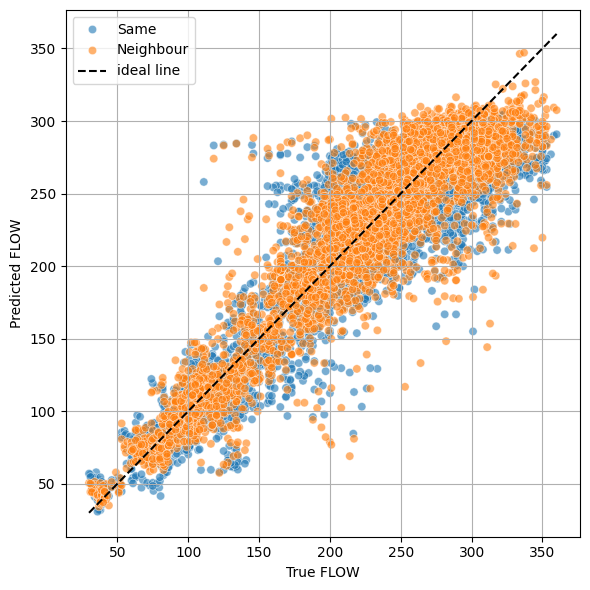

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


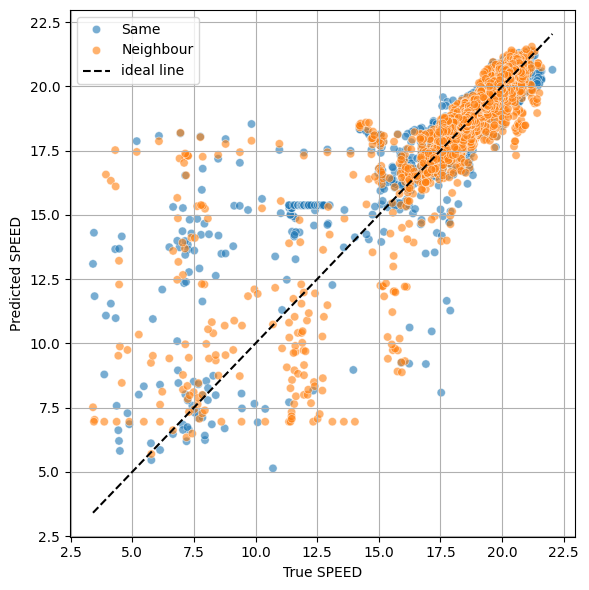

In [81]:
#plot for flow prediction vs true values
#combine prediction and true values for plot
df_plot = pd.DataFrame({
        "y_true": np.concatenate([y_true_flow_same, y_true_flow_neighbour]),
        "y_pred": np.concatenate([y_pred_flow_same, y_pred_flow_neighbour]),
        "source": ["Same"] * len(y_true_flow_same) + ["Neighbour"] * len(y_true_flow_neighbour)
    })
#plot
plt.figure(figsize=(6, 6))
#scatter plot , prediction vs reality, color depending on source (same vs neighbour)
sns.scatterplot(data=df_plot, x="y_true", y="y_pred", hue="source", palette=["#1f77b4", "#ff7f0e"], alpha=0.6)

# ideal line, predcition=true
min_val = df_plot["y_true"].min()
max_val = df_plot["y_true"].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="ideal line")

plt.xlabel("True FLOW")
plt.ylabel("Predicted FLOW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Flow/samevsneighbour.eps")
plt.savefig("Plots/Flow/samevsneighbour.png")
plt.show()    


#plot for speed prediction vs true values
#combine prediction and true values for plot
df_plot = pd.DataFrame({
        "y_true": np.concatenate([y_true_speed_same, y_true_speed_neighbour]),
        "y_pred": np.concatenate([y_pred_speed_same, y_pred_speed_neighbour]),
        "source": ["Same"] * len(y_true_speed_same) + ["Neighbour"] * len(y_true_speed_neighbour)
    })
#plt
plt.figure(figsize=(6, 6))
#scatter plot , prediction vs reality, color depending on source (same vs neighbour)
sns.scatterplot(data=df_plot, x="y_true", y="y_pred", hue="source", palette=["#1f77b4", "#ff7f0e"], alpha=0.6)

#ideal line
min_val = df_plot["y_true"].min()
max_val = df_plot["y_true"].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="ideal line")

plt.xlabel("True SPEED")
plt.ylabel("Predicted SPEED")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Speed/samevsneighbour.eps")
plt.savefig("Plots/Speed/samevsneighbour.png")
plt.show()    





XGB-Boost without NAN-removal

In [82]:
#prepare the dataset with nan-values in the same way (just without filling up values)
#billed lag features for Flow and speed
df_eval_lagged_wnan = build_lag_features(df_eval_2_wnan, 'FLOW', lags=nlags)
df_eval_lagged_wnan = build_lag_features(df_eval_lagged_wnan,"SPEED_MS_AVG", lags=nlags)
#removes the first 15 mins of every day (because there not all lag features are available)
df_eval_lagged_wnan = df_eval_lagged_wnan[df_eval_lagged_wnan["Time_only"]>= time(4, 15)]
#puts lag features for every sensor as columns
df_eval_lagged_all_wnan = []
for sensor in except_target_sensors:
    df_eval_sensor = df_eval_lagged_wnan[df_eval_lagged_wnan['DP_ID'] == sensor].copy()
    df_eval_sensor = df_eval_sensor.rename(columns={
        f'FLOW_lag_{i+1}': f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)
    })
    df_eval_sensor = df_eval_sensor.rename(columns={
        f'SPEED_MS_AVG_lag_{i+1}': f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)
    })
    df_eval_sensor = df_eval_sensor[['Datetime'] + [f'SENSOR_{sensor}_FLOW_lag_{i+1}' for i in range(nlags)]+[f'SENSOR_{sensor}_SPEED_lag_{i+1}' for i in range(nlags)]]
    df_eval_lagged_all_wnan.append(df_eval_sensor)
df_eval_lagged_all_wnan = reduce(lambda l, r: pd.merge(l, r, on='Datetime', how='inner'), df_eval_lagged_all_wnan)
df_eval_lagged_all_wnan=df_eval_lagged_all_wnan.merge(df_eval_2_wnan[df_eval_2_wnan['DP_ID']==target_sensor][["Datetime","FLOW","SPEED_MS_AVG"]], on=['Datetime'], how='left')
#adds the target value (summed flow for upcoming 15 mins)
df_eval_2_wnan['FLOW_future_sum'] = (
    df_eval_2_wnan.groupby('DP_ID')['FLOW']
    .rolling(15, min_periods=15)
    .sum()
    .shift(-14) # so that the sum at  t=07:02 is the sum of the values 07:02–07:16
    .reset_index(level=0, drop=True)
)
#adds the target value (average speed for upcoming 15 mins)
df_eval_2_wnan['SPEED_future_mean'] = (
    df_eval_2_wnan.groupby('DP_ID')['SPEED_MS_AVG']
    .rolling(15, min_periods=15)
    .mean()
    .shift(-14) # so that the mean at  t=07:02 is the mean of the values 07:02–07:16
    .reset_index(level=0, drop=True)
)


df_eval_lagged_all_wnan=df_eval_lagged_all_wnan.merge(df_eval_2_wnan[df_eval_2_wnan['DP_ID']==target_sensor][["Datetime","FLOW_future_sum","SPEED_future_mean"]], on=['Datetime'], how='left')
print(df_eval_lagged_all_wnan.shape)
df_eval_lagged_all_wnan = df_eval_lagged_all_wnan[df_eval_lagged_all_wnan['Datetime'].dt.time <= time(9, 45)]
print(df_eval_lagged_all_wnan.shape)


df_eval_lagged_all_wnan = df_eval_lagged_all_wnan.dropna(subset=["FLOW_future_sum"])
print(df_eval_lagged_all_wnan.isna().sum())


df_eval_lagged_all_peak_wnan=df_eval_lagged_all_wnan.set_index("Datetime").between_time("07:30", "08:30").reset_index()


(30448, 155)
(29128, 155)
Datetime                      0
SENSOR_1254_FLOW_lag_1     1858
SENSOR_1254_FLOW_lag_2     1894
SENSOR_1254_FLOW_lag_3     1929
SENSOR_1254_FLOW_lag_4     1965
                           ... 
SENSOR_536_SPEED_lag_15    2064
FLOW                          0
SPEED_MS_AVG                  0
FLOW_future_sum               0
SPEED_future_mean             0
Length: 155, dtype: int64


In [55]:
#prepare dataframe for results saving
results_df_wnan = pd.DataFrame(columns=["Type", "MAE", "RMSE", "R²"])


In [56]:
#prediction for flow same portal
#load model
filepath="model/xgb_flow_same_nan.json"
model_best_flow_same = XGBRegressor()
model_best_flow_same.load_model(filepath)
#prediction
y_true=df_eval_lagged_all_peak_wnan["FLOW_future_sum"]
y_pred = model_best_flow_same.predict(df_eval_lagged_all_peak_wnan[flow_features_same])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df_wnan = add_result(results_df_wnan, "FLOW -same portal", y_true, y_pred)
print(f"Best FLOW SAME XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_flow_same=y_true
y_pred_flow_same=y_pred

Best FLOW SAME XGB -> RMSE: 29.861, MAE: 22.898, R²: 0.803


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\AppData\Local\Temp\ipykernel_928\1773143569.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  return pd.concat([results_df, pd.DataFrame([new_row])], ignore_index=True)

In [57]:
#prediction for speed same portal
#load model
filepath="model/xgb_speed_same_nan.json"
model_best_speed_same = XGBRegressor()
model_best_speed_same.load_model(filepath)
#prediction
y_true=df_eval_lagged_all_peak_wnan["SPEED_future_mean"]
y_pred = model_best_speed_same.predict(df_eval_lagged_all_peak_wnan[speed_features_same])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df_wnan = add_result(results_df_wnan, "SPEED -same portal", y_true, y_pred)
print(f"Best SPEED SAME XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_speed_same=y_true
y_pred_speed_same=y_pred

Best SPEED SAME XGB -> RMSE: 1.044, MAE: 0.473, R²: 0.739


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [58]:
#prediction for flow neighbour portal
#load model
filepath="model/xgb_flow_neighbour_nan.json"
model_best_flow_neighbour = XGBRegressor()
model_best_flow_neighbour.load_model(filepath)
#prediction
y_true=df_eval_lagged_all_peak_wnan["FLOW_future_sum"]
y_pred = model_best_flow_neighbour.predict(df_eval_lagged_all_peak_wnan[flow_features_neighbour])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df_wnan = add_result(results_df_wnan, "FLOW -neighbour portal", y_true, y_pred)
print(f"Best FLOW NEIGHBOUR XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_flow_neighbour=y_true
y_pred_flow_neighbour=y_pred

Best FLOW NEIGHBOUR XGB -> RMSE: 25.225, MAE: 18.507, R²: 0.859


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [59]:
#prediction for speed neighbour portal
#load model
filepath="model/xgb_speed_neighbour_nan.json"
model_best_speed_neighbour = XGBRegressor()
model_best_speed_neighbour.load_model(filepath)
#prediction
y_true=df_eval_lagged_all_peak_wnan["SPEED_future_mean"]
y_pred = model_best_speed_neighbour.predict(df_eval_lagged_all_peak_wnan[speed_features_neighbour])
rmse = mean_squared_error(y_true, y_pred, squared=False)
mae  = mean_absolute_error(y_true, y_pred)
r2   = r2_score(y_true, y_pred)
results_df_wnan = add_result(results_df_wnan, "SPEED -neighbour portal", y_true, y_pred)
print(f"Best SPEED NEIGHBOUR XGB -> RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")
#rename for figure
y_true_speed_neighbour=y_true
y_pred_speed_neighbour=y_pred

Best SPEED NEIGHBOUR XGB -> RMSE: 1.110, MAE: 0.502, R²: 0.704


C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\Johanna\anaconda3\envs\AI_project\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


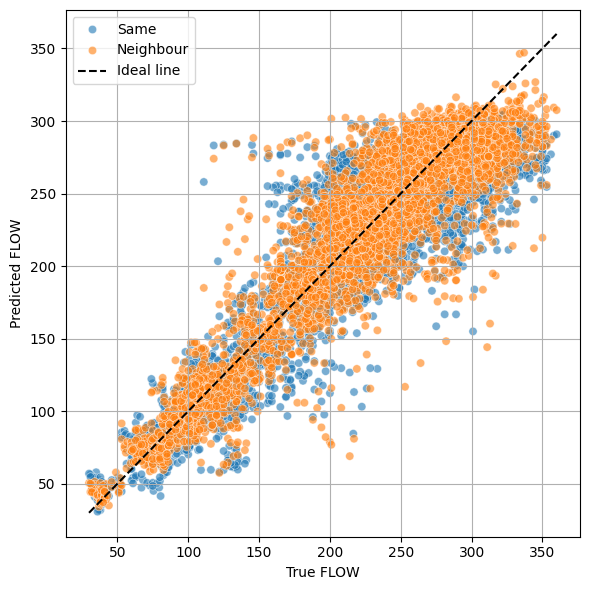

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


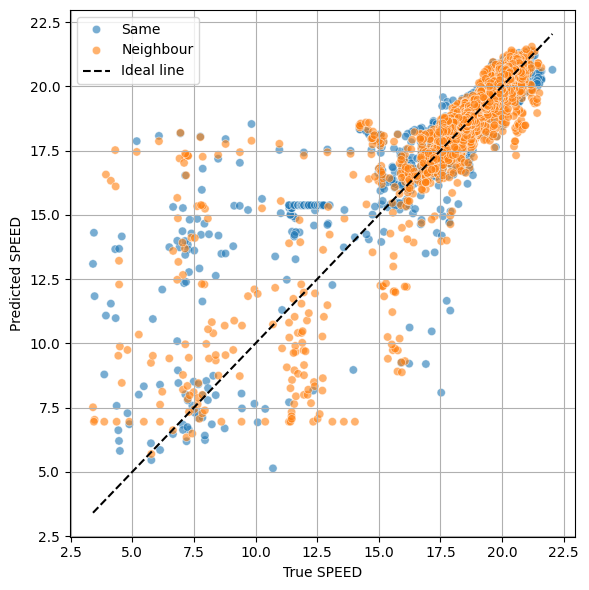

In [83]:
#plot for flow prediction vs true values
#combine prediction and true values for plot
df_plot = pd.DataFrame({
        "y_true": np.concatenate([y_true_flow_same, y_true_flow_neighbour]),
        "y_pred": np.concatenate([y_pred_flow_same, y_pred_flow_neighbour]),
        "Quelle": ["Same"] * len(y_true_flow_same) + ["Neighbour"] * len(y_true_flow_neighbour)
    })
#plt
plt.figure(figsize=(6, 6))
#scatter plot , prediction vs reality, color depending on source (same vs neighbour)
sns.scatterplot(data=df_plot, x="y_true", y="y_pred", hue="Quelle", palette=["#1f77b4", "#ff7f0e"], alpha=0.6)

# ideal line, predcition=true
min_val = df_plot["y_true"].min()
max_val = df_plot["y_true"].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Ideal line")
plt.xlabel("True FLOW")
plt.ylabel("Predicted FLOW")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Flow/samevsneighbour_nan.eps")
plt.savefig("Plots/Flow/samevsneighbour_nan.png")

plt.show()    

#plot for flow prediction vs true values
#combine prediction and true values for plot
df_plot = pd.DataFrame({
        "y_true": np.concatenate([y_true_speed_same, y_true_speed_neighbour]),
        "y_pred": np.concatenate([y_pred_speed_same, y_pred_speed_neighbour]),
        "Quelle": ["Same"] * len(y_true_speed_same) + ["Neighbour"] * len(y_true_speed_neighbour)
    })
#plot
plt.figure(figsize=(6, 6))
#scatter plot , prediction vs reality, color depending on source (same vs neighbour)
sns.scatterplot(data=df_plot, x="y_true", y="y_pred", hue="Quelle", palette=["#1f77b4", "#ff7f0e"], alpha=0.6)

# ideal line, predcition=true
min_val = df_plot["y_true"].min()
max_val = df_plot["y_true"].max()
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label="Ideal line")

plt.xlabel("True SPEED")
plt.ylabel("Predicted SPEED")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("Plots/Speed/samevsneighbour_nan.eps")
plt.savefig("Plots/Speed/samevsneighbour_nan.png")
plt.show()    



